<a href="https://colab.research.google.com/github/sudharson-c/ocv-projects/blob/main/License_Plate_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python-headless pytesseract


In [2]:
!apt-get update
!apt-get install -y tesseract-ocr


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,196 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,628 kB]
Get:13 http://security.ubuntu.com/ubun

In [3]:
!tesseract --version


tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [4]:
from google.colab import files
uploaded = files.upload()  # Upload your license plate image


Saving image1.jpg to image1.jpg


In [5]:
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 20.8 MB/s eta 0:00:00


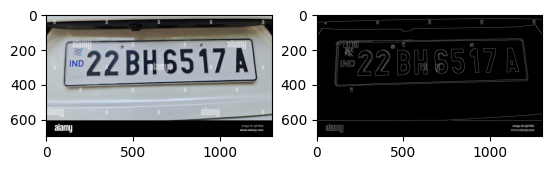

Tesseract OCR Result: License plate not detected.
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [11]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import easyocr

pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Adjust for your environment

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 200)
    return image, edges

def find_license_plate(image, edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            if 2 < w/h < 5 and w > 100 and h > 30:
                return image[y:y+h, x:x+w]
    return None

def recognize_text_tesseract(license_plate):
    if license_plate is not None:
        gray_plate = cv2.cvtColor(license_plate, cv2.COLOR_BGR2GRAY)
        _, threshold_plate = cv2.threshold(gray_plate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        morphed_plate = cv2.morphologyEx(threshold_plate, cv2.MORPH_CLOSE, kernel)
        text = pytesseract.image_to_string(morphed_plate, config="--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
        return text.strip()
    return "License plate not detected."

def recognize_text_easyocr(license_plate):
    reader = easyocr.Reader(['en'])
    results = reader.readtext(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))
    return results[0][-2] if results else "License plate not detected."

def main(image_path):
    image, edges = preprocess_image(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.show()

    license_plate = find_license_plate(image, edges)
    if license_plate is not None:
        plt.imshow(cv2.cvtColor(license_plate, cv2.COLOR_BGR2RGB))
        plt.show()

    text_tesseract = recognize_text_tesseract(license_plate)
    print("Tesseract OCR Result:", text_tesseract)

    text_easyocr = recognize_text_easyocr(license_plate)
    print("EasyOCR Result:", text_easyocr)

uploaded_image_path = list(uploaded.keys())[0]
main(uploaded_image_path)

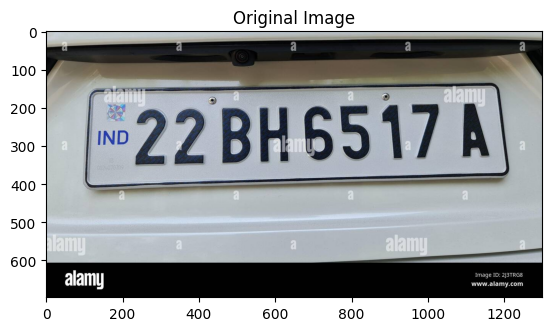

In [10]:
import matplotlib.pyplot as plt

# Show the original image
image = cv2.imread(uploaded_image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.show()
